In [22]:
import tensorflow as tf
import os

# Dataset paths
DATASET_PATH = "/Users/harshavardhan/Downloads/gan-getting-started"

# Define paths for each domain
DOMAIN_X_PATH = os.path.join(DATASET_PATH, "photo_jpg") 
DOMAIN_Y_PATH = os.path.join(DATASET_PATH, "monet_jpg")

# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 32  

def load_image(file_path):
    """Loads and preprocesses an image."""
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_dataset(path):
    """Load and preprocess dataset."""
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

# Load the datasets
dataset_X = load_dataset(DOMAIN_X_PATH)
dataset_Y = load_dataset(DOMAIN_Y_PATH)

In [23]:
from tensorflow.keras import layers, Model

def build_generator():
    """Builds a ResNet-based generator."""
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # Add layers here (e.g., Convolutional, Residual, and Upsampling blocks)
    x = layers.Conv2D(64, (7, 7), padding='same', activation='relu')(inputs)
    # Add additional ResNet blocks and upsampling
    outputs = layers.Conv2D(3, (7, 7), activation='tanh', padding='same')(x)
    return Model(inputs, outputs)

def build_discriminator():
    """Builds a PatchGAN discriminator."""
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # Add more convolutional layers with increasing filters
    x = layers.Conv2D(1, (4, 4), padding='same')(x)
    outputs = layers.Activation('sigmoid')(x)
    return Model(inputs, outputs)

# Define models
generator_G = build_generator()  # X -> Y
generator_F = build_generator()  # Y -> X
discriminator_X = build_discriminator()  # Discriminator for X
discriminator_Y = build_discriminator()  # Discriminator for Y


In [24]:
# Loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    """Compute the discriminator loss."""
    real_loss = loss_object(tf.ones_like(real), real)
    fake_loss = loss_object(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake):
    """Compute the generator adversarial loss."""
    return loss_object(tf.ones_like(fake), fake)

def cycle_consistency_loss(real_image, cycled_image):
    """Cycle consistency loss."""
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    """Identity loss."""
    return tf.reduce_mean(tf.abs(real_image - same_image))


In [25]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

def train_step(real_X, real_Y):
    """One training step."""
    with tf.GradientTape(persistent=True) as tape:
        # Generator forward pass
        fake_Y = generator_G(real_X, training=True)
        cycled_X = generator_F(fake_Y, training=True)

        fake_X = generator_F(real_Y, training=True)
        cycled_Y = generator_G(fake_X, training=True)

        # Identity mapping
        same_X = generator_F(real_X, training=True)
        same_Y = generator_G(real_Y, training=True)

        # Discriminator predictions
        disc_real_X = discriminator_X(real_X, training=True)
        disc_fake_X = discriminator_X(fake_X, training=True)

        disc_real_Y = discriminator_Y(real_Y, training=True)
        disc_fake_Y = discriminator_Y(fake_Y, training=True)

        # Losses
        gen_G_loss = generator_loss(disc_fake_Y)
        gen_F_loss = generator_loss(disc_fake_X)

        cycle_loss = cycle_consistency_loss(real_X, cycled_X) + cycle_consistency_loss(real_Y, cycled_Y)
        id_loss = identity_loss(real_X, same_X) + identity_loss(real_Y, same_Y)

        total_gen_G_loss = gen_G_loss + cycle_loss + id_loss
        total_gen_F_loss = gen_F_loss + cycle_loss + id_loss

        disc_X_loss = discriminator_loss(disc_real_X, disc_fake_X)
        disc_Y_loss = discriminator_loss(disc_real_Y, disc_fake_Y)

    # Apply gradients
    generator_G_gradients = tape.gradient(total_gen_G_loss, generator_G.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, generator_F.trainable_variables)

    discriminator_X_gradients = tape.gradient(disc_X_loss, discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, discriminator_Y.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_G_gradients, generator_G.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_F_gradients, generator_F.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_X_gradients, discriminator_X.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_Y_gradients, discriminator_Y.trainable_variables))


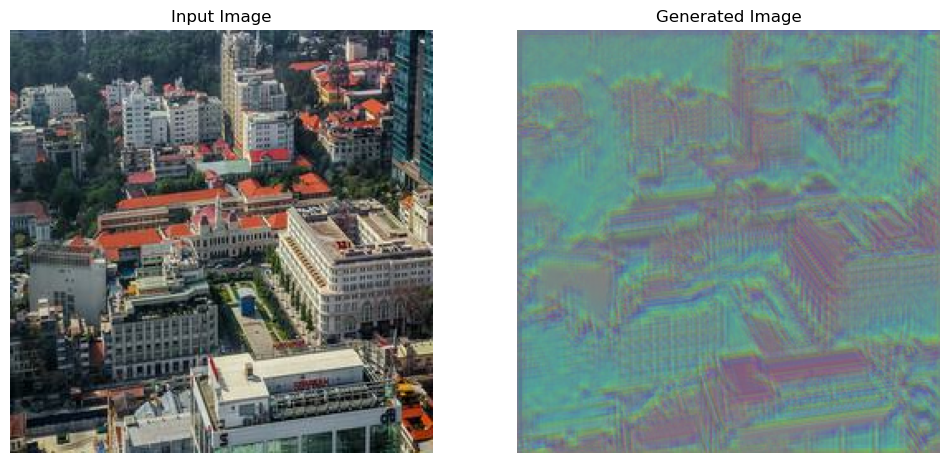

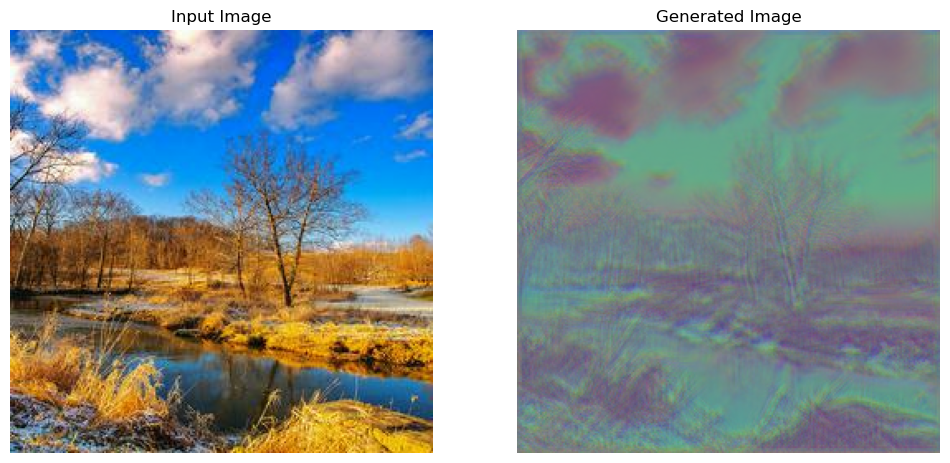

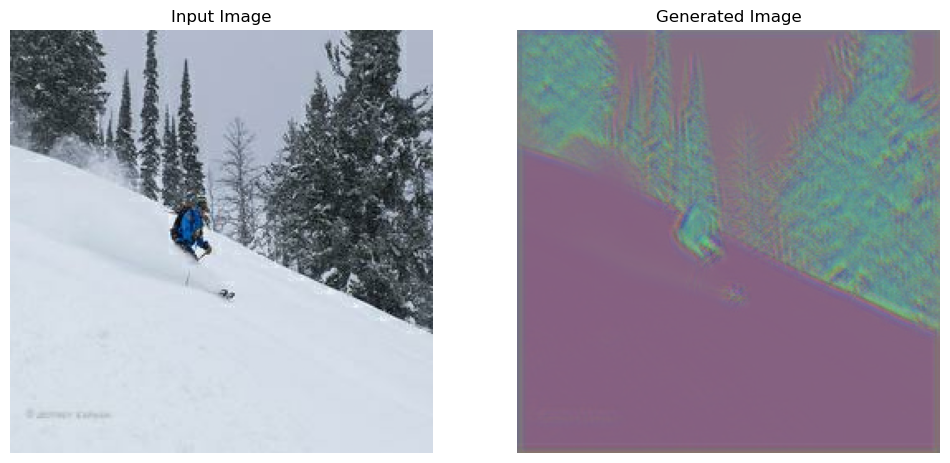

In [26]:
import matplotlib.pyplot as plt

def generate_images(model, test_input):
    """Generate and display images."""
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    titles = ['Input Image', 'Generated Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Rescale to [0, 1]
        plt.axis('off')
    plt.show()

# Example usage
for test_image in dataset_X.take(3):
    generate_images(generator_G, test_image)
